In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
# set font family to LaTeX default
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.dpi": 300,
})

In [2]:
def funnel_modification(df):
    for sampler_type in df["sampler_type"].unique():
        filtered = df[df["sampler_type"] == sampler_type]

        row1 = filtered[filtered["error"] == "error_log_scale"]
        row2 = filtered[filtered["error"] == "error_latent"]

        if row1["mean"].values > row2["mean"].values:
            df = df.drop(row2.index)
            df.loc[row1.index, "error"] = "error_param"
        else:
            df = df.drop(row1.index)
            df.loc[row2.index, "error"] = "error_param"

        row1 = filtered[filtered["error"] == "error_log_scale_squared"]
        row2 = filtered[filtered["error"] == "error_latent_squared"]

        if row1["mean"].values > row2["mean"].values:
            df = df.drop(row2.index)
            df.loc[row1.index, "error"] = "error_param_squared"
        else:
            df = df.drop(row1.index)
            df.loc[row2.index, "error"] = "error_param_squared"
    return df

In [3]:
posteriors = ["funnel10", "funnel50", "eight_schools-eight_schools_centered", "stochastic_volatility", "irt_2pl", "normal100"]
data = []

for posterior in posteriors:
    fname = f"../../doc/figures/{posterior}/baseline/normalized_error.csv"
    df = pd.read_csv(fname, dtype={"mean": float})
    
    if posterior == "funnel10":
        df = funnel_modification(df)
        
    df["Posterior"] = posterior if posterior != "eight_schools-eight_schools_centered" else "eight_schools"
    data.append(df)
df = pd.concat(data, ignore_index=True)

df = df.replace("drhmc", "DR-HMC").replace("drghmc", "DR-GHMC").replace("nuts", "NUTS")
df = df.rename(columns={"sampler_type": "Sampler"})

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set(**kwargs)


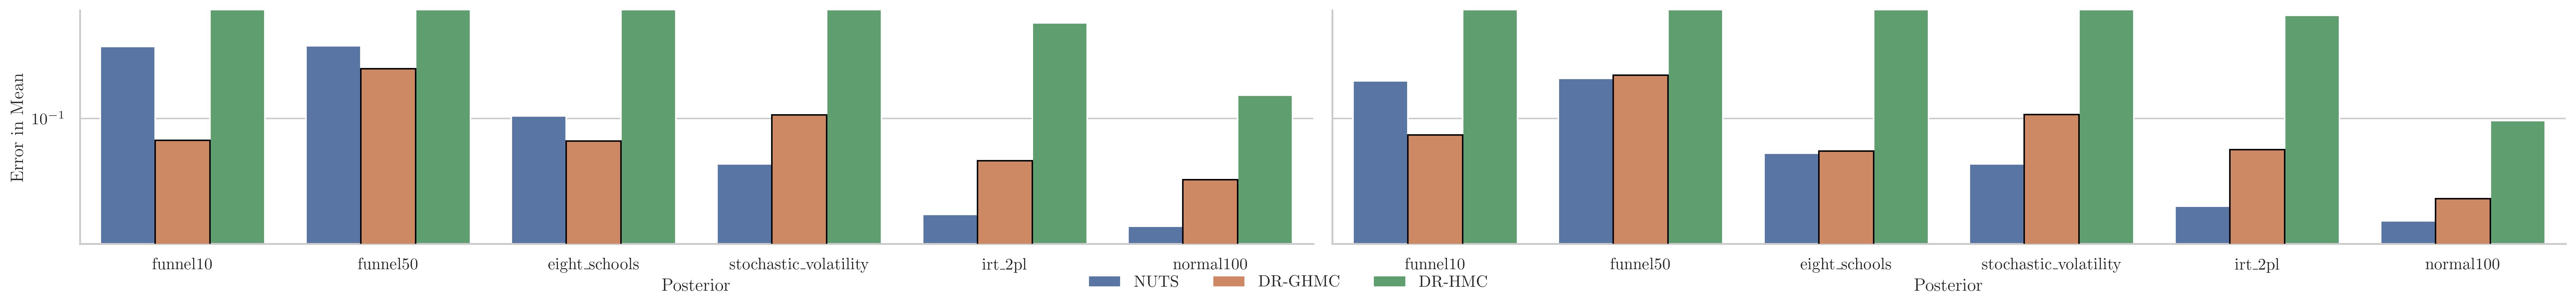

In [6]:
fig = sns.catplot(
    data=df,
    kind="bar",
    x="Posterior",
    y="mean",
    hue="Sampler",
    hue_order=["NUTS", "DR-GHMC", "DR-HMC"],
    col="error",
    height=3,
    aspect=4,
    sharex=True,
)

# move seaborn facetgrid legend to bottom center with three columns
fig.figure.subplots_adjust(bottom=0.15)
sns.move_legend(fig, "lower center", ncol=3, title="")

fig.set(yscale="log")
fig.set(ylim=(0, 0.5))

fig.axes.flat[0].set_title("")
fig.axes.flat[1].set_title("")

# fig.axes.flat[0].set_xlabel("")
# fig.axes.flat[1].set_xlabel("")

# add latex L to represent the error $L$
fig.axes.flat[0].set_ylabel("Error in Mean")
fig.axes.flat[1].set_ylabel("Error in Variance")


# if sampler_type is "drghmc", set the bar linewidth to black
facecolor_drghmc =(0.7985294117647057, 0.536764705882353, 0.38970588235294135, 1)
for ax in fig.axes.flat:
    for bar in ax.patches:
        if bar.get_facecolor() == facecolor_drghmc:
            bar.set_linewidth(1)
            bar.set_edgecolor("black")
            bar.set_zorder(10)
        
# fig.figure.subplots_adjust(top=0.9)
# fig.figure.suptitle("Sampler Error Across Different Posteriors")
# display the figure in high resolution for LaTex document
fig.savefig("../../doc/figures/sampler_error.pdf", dpi=300)